# Time Series Models - Arima & Prophet

Video Part 1:
- What is a Time Series Model?
- Importing / Installing packages
- Problem Formulation - What are we trying to solve?
- Reading / Loading the Raw Data into Python From CSV
- Data Pre-Processing Phase
- Splitting the Raw Data
- Running Arima (Autoregressive Integrated Moving Average) - 1 Country
- Parameter Tuning
- Running Auto-Arima

Video Part 2:
- Running Prophet
- Running Arima & Auto-Arima Together
- Running Arima, Auto-Arima, Prophet & Linear Regression Together
- Storing the outputs all together
- Fixing bugs in for loops
- Running all models on all countries
- Combining actuals with predictions
- Exporting the Data

Video Part 3:
- Power BI


### 1. What is a Time Series Model?

- Time series are series of data points listed in time order

- Time series forecasting is the use of a model to predict future values based on previously observed values.

Process:

- Similar with the Machine Learning process but the inputs are limited to 2

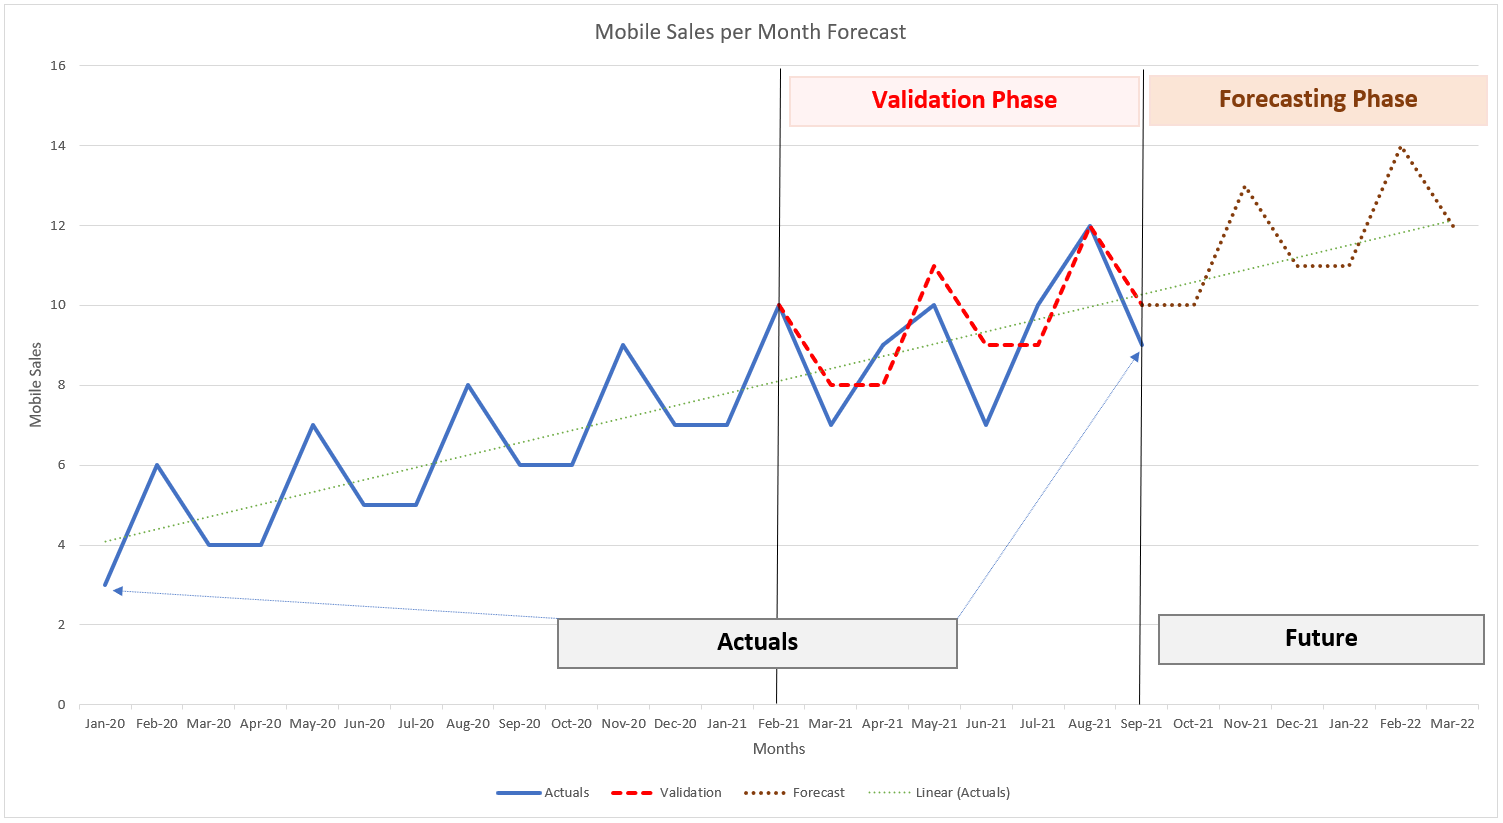

In [1]:
### Graphical Time Series

import os
from IPython.display import Image
PATH = "F:\\Github\\Python tutorials\\Time Series\\"
Image(filename = PATH + "Time Series.png", width=900, height=900)

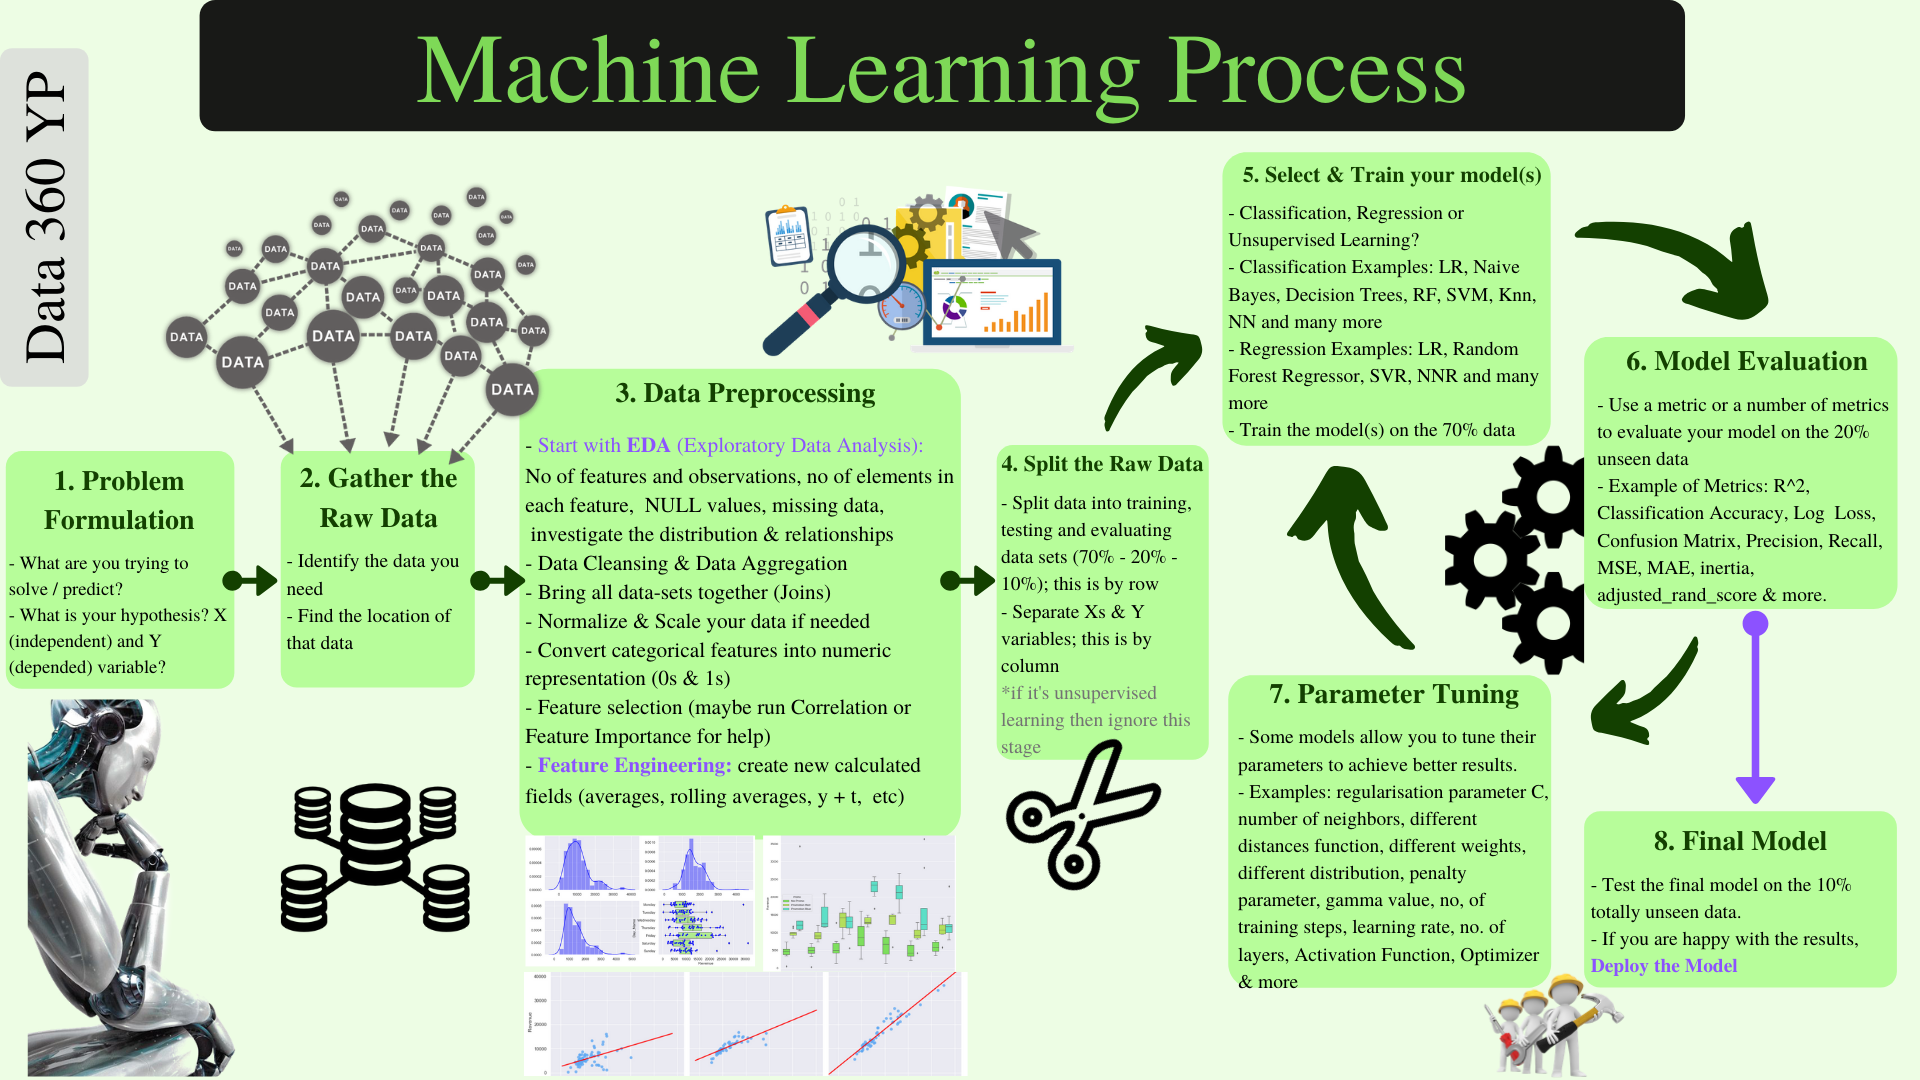

In [2]:
### Graphical ML Process

PATH = "F:\\Github\\Python tutorials\\Introduction to ML - LR model\\"
Image(filename = PATH + "Machine Learning.png", width=900, height=900)

# Machine Learning Full Explanation:
# https://youtu.be/vfA1ZKN4Y40 

### 2. Importing / Installing packages

In [3]:
# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# To install sklearn type "pip install numpy scipy scikit-learn" to the anaconda terminal

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

#ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import pmdarima as pm
from pmdarima.model_selection import train_test_split

from fbprophet import Prophet

from pandas import to_datetime

import itertools
import warnings

import datetime
from datetime import datetime
warnings.filterwarnings('ignore')

# installing auto arima
# pip install --user pmdarima

# installing fbprophet
# pip install --user fbprophet
# !pip install --upgrade plotly

### 3. Problem Formulation - What are we trying to solve?

- We want to forecast the GDP per Capita per country for the next 7 to 10 years

### 4.1 Reading / Loading the Raw Data into Python from SQL

In [4]:
#################################################################################################################
##############################   Getting the file from SQL Server      ##########################################
#################################################################################################################

import pypyodbc as podbc

conn2 = podbc.connect("Driver={SQL Server Native Client 11.0};"
                     "Server=DESKTOP-8L98FK0\MSSQLSERVER09;"
                     "Database=Data360YP;"
                     "Trusted_Connection=yes;")

# rynning the SQL quey i need
SQL_Query = pd.read_sql_query('''SELECT * FROM [dbo].[Raw_Data_GDP]''', conn2)

#conn.close()

# print the shape
print(SQL_Query.shape)

# Viz
SQL_Query.head()

(270038, 8)


,demo_ind,indicator,location,country,time,value,flag codes,flags
0,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1970,2.86,None,None
1,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1971,2.96,None,None
2,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1972,2.74,None,None
3,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1973,2.49,None,None
4,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1974,2.40,None,None


### 4.2 Reading / Loading the Raw Data into Python From CSV

In [5]:
#################################################################################################################
################################ Getting the file from local CSV      ###########################################
#################################################################################################################

# Loading the data
raw_data = pd.read_csv('F:\\Github\Python tutorials\\Time Series\\gdp_raw_data.csv', encoding='latin-1')

# print the shape
print(raw_data.shape)

#runs the first 5 rows
raw_data.head()

(270038, 8)


,demo_ind,indicator,location,country,time,value,flag codes,flags
0,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1970,2.86,NaN,NaN
1,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1971,2.96,NaN,NaN
2,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1972,2.74,NaN,NaN
3,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1973,2.49,NaN,NaN
4,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1974,2.40,NaN,NaN


### 5. Data Pre-Processing Phase

In [6]:
# Checking for null values
SQL_Query.isnull().sum()

demo_ind           0
indicator          0
location           0
country            0
time               0
value           2066
flag codes    267972
flags         267972
dtype: int64

In [7]:
SQL_Query['indicator'][SQL_Query['value'].isnull()].unique()

array(['Population growth (annual %)',
       'Rural population (% of total population)',
       'GDP deflator (base year varies by country)',
       'GDP growth (annual %)',
       'Poverty headcount ratio at $1.90 a day (PPP) (% of population)',
       'PPP conversion factor, GDP (LCU per international $)',
       'Total debt service (% of GNI)', 'GNI per capita (current LCU)',
       'Official exchange rate (LCU per US$, period average)',
       'GDP per capita (current LCU)',
       'PPP conversion factor, private consumption (LCU per international $)',
       'DEC alternative conversion factor (LCU per US$)'], dtype=object)

In [8]:
# Deleting the NULL values
SQL_Query = SQL_Query.dropna(subset = ['value'])

# filtering out the last 2 columns
SQL_Query = SQL_Query[['demo_ind','indicator','location','country','time','value']]

# Checking for null values
SQL_Query.isnull().sum()

demo_ind     0
indicator    0
location     0
country      0
time         0
value        0
dtype: int64

In [9]:
# Investigate all the elements whithin each Feature 

for column in SQL_Query:
    unique_vals = np.unique(SQL_Query[column])
    nr_values = len(unique_vals)
    if nr_values < 36:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature demo_ind :35 -- ['200101' '200144' '200151' '200343' '200345' 'DT_TDS_DECT_GN_ZS'
 'NY_GDP_DEFL_ZS' 'NY_GDP_MKTP_CD' 'NY_GDP_MKTP_CN' 'NY_GDP_MKTP_KD'
 'NY_GDP_MKTP_KD_ZG' 'NY_GDP_MKTP_KN' 'NY_GDP_MKTP_PP_CD'
 'NY_GDP_MKTP_PP_KD' 'NY_GDP_PCAP_CD' 'NY_GDP_PCAP_CN' 'NY_GDP_PCAP_PP_CD'
 'NY_GDP_PCAP_PP_KD' 'NY_GNP_MKTP_CN' 'NY_GNP_PCAP_CD' 'NY_GNP_PCAP_CN'
 'NY_GNP_PCAP_PP_CD' 'PA_NUS_ATLS' 'PA_NUS_FCRF' 'PA_NUS_PPP'
 'PA_NUS_PPPC_RF' 'PA_NUS_PRVT_PP' 'SH_DYN_AIDS_ZS' 'SI_POV_DDAY'
 'SP_DYN_IMRT_IN' 'SP_DYN_LE00_IN' 'SP_DYN_TFRT_IN' 'SP_POP_GROW'
 'SP_RUR_TOTL_ZS' 'XTGOV_IMF']
The number of values for feature indicator :35 -- ['DEC alternative conversion factor (LCU per US$)'
 'Fertility rate, total (births per woman)' 'GDP (constant LCU)'
 'GDP (current LCU)' 'GDP (current US$)'
 'GDP at market prices (constant 2010 US$)'
 'GDP deflator (base year varies by country)' 'GDP growth (annual %)'
 'GDP per capita (current LCU)' 'GDP per capita (current US$)'
 '

In [10]:
# Filtering out the data we need - GDP per Capita
forecast_data = SQL_Query[SQL_Query['indicator'] == 'GDP per capita, PPP (current international $)']

forecast_data = forecast_data[~forecast_data['country'].isin(['Djibouti', 'South Sudan', 'Curaþao', 'Eritrea', 'Bermuda', 'Venezuela (Bolivarian Republic of)'])]

forecast_data.head()

,demo_ind,indicator,location,country,time,value
76848,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1990,17333.10
76849,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1991,17793.60
76850,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1992,18189.34
76851,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1993,19130.89
76852,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1994,20063.81


In [11]:
# Limiting the columns we need
forecast_data = forecast_data[['country','time','value']]
forecast_data.head()

,country,time,value
76848,Australia,1990,17333.10
76849,Australia,1991,17793.60
76850,Australia,1992,18189.34
76851,Australia,1993,19130.89
76852,Australia,1994,20063.81


In [12]:
# Changing the time to date - Most Time Series Models require date structure
forecast_data['time'] = forecast_data['time'].astype(str) + '-01-01'
forecast_data['time'] = pd.to_datetime(forecast_data['time'])

forecast_data.head()

,country,time,value
76848,Australia,1990-01-01,17333.10
76849,Australia,1991-01-01,17793.60
76850,Australia,1992-01-01,18189.34
76851,Australia,1993-01-01,19130.89
76852,Australia,1994-01-01,20063.81


### 6. Spliting the Raw Data

In [13]:
X_train = forecast_data[forecast_data['time'] < '2012-01-01']
X_valid = forecast_data[forecast_data['time'] >= '2011-01-01']

print('X_train Shape', X_train.shape)
print('X_Valid Shape', X_valid.shape)

X_train['time'].unique()

X_train Shape (3966, 3)
X_Valid Shape (1322, 3)


array(['1990-01-01T00:00:00.000000000', '1991-01-01T00:00:00.000000000',
       '1992-01-01T00:00:00.000000000', '1993-01-01T00:00:00.000000000',
       '1994-01-01T00:00:00.000000000', '1995-01-01T00:00:00.000000000',
       '1996-01-01T00:00:00.000000000', '1997-01-01T00:00:00.000000000',
       '1998-01-01T00:00:00.000000000', '1999-01-01T00:00:00.000000000',
       '2000-01-01T00:00:00.000000000', '2001-01-01T00:00:00.000000000',
       '2002-01-01T00:00:00.000000000', '2003-01-01T00:00:00.000000000',
       '2004-01-01T00:00:00.000000000', '2005-01-01T00:00:00.000000000',
       '2006-01-01T00:00:00.000000000', '2007-01-01T00:00:00.000000000',
       '2008-01-01T00:00:00.000000000', '2009-01-01T00:00:00.000000000',
       '2010-01-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

### 7. Running Arima (Autoregressive Integrated Moving Average) - 1 Country

ARIMA:
- Uses a number of lagged observations of time series to forecast observations

Inputs / Parameters:
- p: the number of lag observations in the model; also known as the lag order (AR)
- d: the number of times that the raw observations are differenced; also known as the degree of differencing (I)
- q: the size of the moving average window; also known as the order of the moving average (MA)

Source / Read more about how it works: https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp


In [14]:
########################################################################################################
####################################### Running ARIMA on Australia #####################################
########################################################################################################

# filtering the train data
au = X_train[X_train['country'] == 'Australia']
au2 = au[['time', 'value']]

#filtering the valid data
au_v = X_valid[X_valid['country'] == 'Australia']
au_v2 = au_v[['time', 'value']]

# set the date into index
au2.set_index('time', inplace=True)
au_v2.set_index('time', inplace=True)

# Setting the Index for 6 years
index_7_years = pd.date_range(au2.index[-1], freq='AS', periods = 7) 

index_7_years

DatetimeIndex(['2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [15]:
len(X_train['country'].unique())

189

The MSE of ARIMA is: 1838.1413636212956


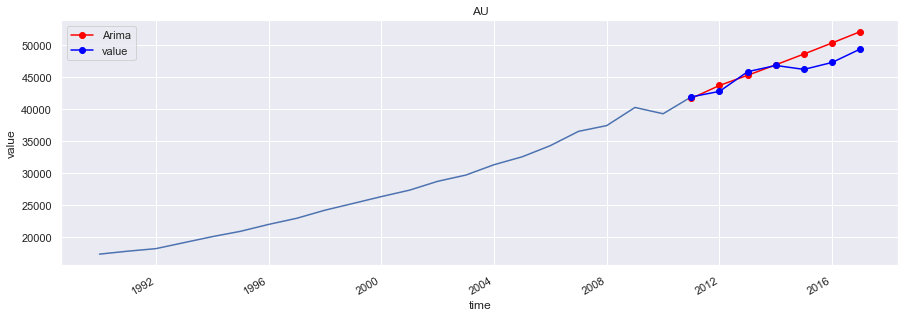

In [16]:
# Running ARIMA with random numbers
model_arima = ARIMA(au2, order=(0,2,3)) # start 2-0-0 and move to the best
model_arima_fit = model_arima.fit(disp=-1)

# Saving ARIMA predictions
fcast1 = model_arima_fit.forecast(7)[0]

# Passing the same index as the others
fcast1 = pd.Series(fcast1, index=index_7_years)
fcast1 = fcast1.rename("Arima") 

# Ploting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='time', y='value', data = au)
chart.set_title('AU')
fcast1.plot(ax=ax, color='red', marker="o", legend=True)
au_v2.plot(ax=ax, color='blue', marker="o", legend=True)

# Printing the AI
print('The MSE of ARIMA is:', mean_squared_error(au_v['value'].values, fcast1.values, squared=False))

In [17]:
###### Option 1: Finding the best value for ARIMA

import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    try:
        model_arima = ARIMA(au2,order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue
    
# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
# statistical models for a given set of data

# It's like the mean squared error in Regression - The smaller the number, the better

(0, 0, 0) 460.0842007079433
(0, 0, 1) 439.3169435354762
(0, 0, 2) 424.29239844537346
(0, 1, 0) 343.29855716475754
(0, 1, 1) 342.1347269787415
(0, 1, 2) 334.76753608318336
(0, 1, 3) 334.11245138211444
(0, 1, 4) 331.3840522148887
(0, 2, 0) 348.12476526480964
(0, 2, 1) 329.9389576555131
(0, 2, 2) 327.9243756676344
(0, 2, 3) 322.2395887106426
(0, 2, 4) nan
(1, 0, 0) 391.58586028672335
(1, 1, 0) 338.7412422866265
(1, 1, 2) 329.21732085575616
(1, 2, 0) 352.5900843899617
(2, 0, 0) 386.74749564285094
(4, 1, 0) 324.1353161978933
(4, 2, 0) 357.0909590136696


The RMSE of auto-arima is: 3484.9681189113


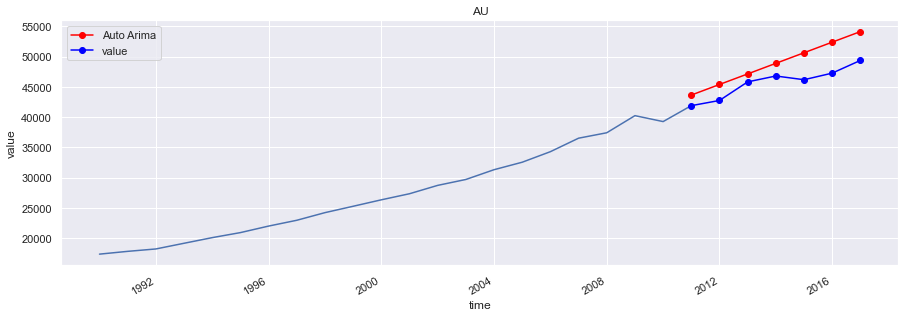

In [18]:
###### Option 2: Auto ARIMA

# Running auto ARIMA 
auto_arima_model = pm.auto_arima(au2, seasonal=False, m=7)

# Read more about setting m
# https://alkaline-ml.com/pmdarima/tips_and_tricks.html

# make your forecasts
fcast2 = auto_arima_model.predict(7) 
fcast2 = pd.Series(fcast2, index=index_7_years)
fcast2 = fcast2.rename("Auto Arima")

# Ploting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='time', y='value', data = au)
chart.set_title('AU')
fcast2.plot(ax=ax, color='red', marker="o", legend=True)
au_v2.plot(ax=ax, color='blue', marker="o", legend=True)

# Printing the AI
print('The RMSE of auto-arima is:', mean_squared_error(au_v['value'].values, fcast2.values, squared=False))